In [310]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [311]:
# Load dataset
file_path = 'dataset/amazon_laptop_prices_v01.csv'
laptopData = pd.read_csv(file_path)

laptopData.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price
0,acer,Chromebook 511 C741LT,11.6 Inches,Shale Black,32 GB,AMD Kabini A6-5200M Quad Core,4 GB,Chrome OS,Backlit,Dedicated,NaN,NaN,NaN,$529.53
1,Dell,Inspiron 7415 2-in-1,14 Inches,Grey,512 GB,AMD Ryzen 7,8 GB,Windows 11 Home,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,$633.99
2,Dell,Inspiron 7415 2-in-1,14 Inches,Grey,256 GB,AMD Ryzen 7,8 GB,Windows 11 Pro,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,$577.49
3,Dell,Inspiron 7415 2-in-1,14 Inches,Grey,256 GB,AMD Ryzen 7,12 GB,Windows 11 Home,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,$602.47
4,Dell,Inspiron 7415 2-in-1,14 Inches,Grey,256 GB,AMD Ryzen 7,12 GB,Windows 11 Home,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,$602.47


In [312]:
# Function to convert storage values (harddisk, ram) to numerical format in GB
def convert_os(os_val):
    if pd.isna(os_val):
        return np.nan
    if 'mac' in os_val:
        return 'macOS'
    if 'Mac' in os_val:
        return 'macOS'
    if 'Chrome' in os_val:
        return 'Chrome OS'
    return 'Windows'

def convert_storage_to_gb(storage_value):
    if pd.isna(storage_value):
        return np.nan
    if isinstance(storage_value, float):
        return storage_value
    if 'TB' in storage_value:
        return float(storage_value.replace('TB', '')) * 1000
    if 'GB' in storage_value:
        return float(storage_value.replace('GB', ''))
    if 'MB' in storage_value:
        return float(storage_value.replace('MB', '')) / 1000
    return np.nan

# Cleansing the screen_size, harddisk, ram, and price columns
if laptopData['screen_size'].dtype == 'O':  # 'O' stands for object, typically used for strings
    laptopData['screen_size'] = laptopData['screen_size'].str.replace(' Inches', '').astype(float)
laptopData['harddisk'] = laptopData['harddisk'].apply(convert_storage_to_gb)
laptopData['ram'] = laptopData['ram'].apply(convert_storage_to_gb)
laptopData['price'] = laptopData['price'].replace('[\$,]', '', regex=True).astype(float)
laptopData['OS'] = laptopData['OS'].apply(convert_os)


# Displaying the cleansed data
laptopData.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price
0,acer,Chromebook 511 C741LT,11.6,Shale Black,32.0,AMD Kabini A6-5200M Quad Core,4.0,Chrome OS,Backlit,Dedicated,NaN,NaN,NaN,529.53
1,Dell,Inspiron 7415 2-in-1,14.0,Grey,512.0,AMD Ryzen 7,8.0,Windows,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,633.99
2,Dell,Inspiron 7415 2-in-1,14.0,Grey,256.0,AMD Ryzen 7,8.0,Windows,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,577.49
3,Dell,Inspiron 7415 2-in-1,14.0,Grey,256.0,AMD Ryzen 7,12.0,Windows,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,602.47
4,Dell,Inspiron 7415 2-in-1,14.0,Grey,256.0,AMD Ryzen 7,12.0,Windows,Wifi & Bluetooth,Integrated,NaN,NaN,NaN,602.47


In [313]:
# Calculating the percentage of missing values in each column
missing_values_percentage = laptopData.isnull().mean() * 100

# Displaying the percentage of missing values
missing_values_percentage.sort_values(ascending=False)

cpu_speed               65.811966
special_features        53.801170
rating                  51.102114
graphics_coprocessor    42.105263
model                   26.180837
color                   13.022942
harddisk                13.022942
cpu                      2.249213
graphics                 1.461988
ram                      1.372020
screen_size              0.652272
OS                       0.584795
price                    0.112461
brand                    0.000000
dtype: float64

In [314]:
# Dropping columns with very high missing values
columns_to_drop = ['model', 'color', 'special_features', 'graphics_coprocessor', 'cpu_speed', 'rating']
laptopData_cleaned = laptopData.drop(columns=columns_to_drop)

# Imputing missing values for numerical column (harddisk) with median
laptopData_cleaned['harddisk'] = laptopData_cleaned['harddisk'].fillna(laptopData_cleaned['harddisk'].median())

# Imputing missing values for categorical columns (cpu, graphics, ram, screen_size, OS) with mode
categorical_columns = ['cpu', 'graphics', 'ram', 'screen_size', 'OS']
for col in categorical_columns:
    laptopData_cleaned[col] = laptopData_cleaned[col].fillna(laptopData_cleaned[col].mode()[0])

# Removing rows where 'price' is missing
laptopData_cleaned = laptopData_cleaned.dropna(subset=['price'])

# Checking the dataset after removing rows with missing target variable
laptopData_cleaned.isnull().sum()  # Displaying the count of missing values in each column after removal

brand          0
screen_size    0
harddisk       0
cpu            0
ram            0
OS             0
graphics       0
price          0
dtype: int64

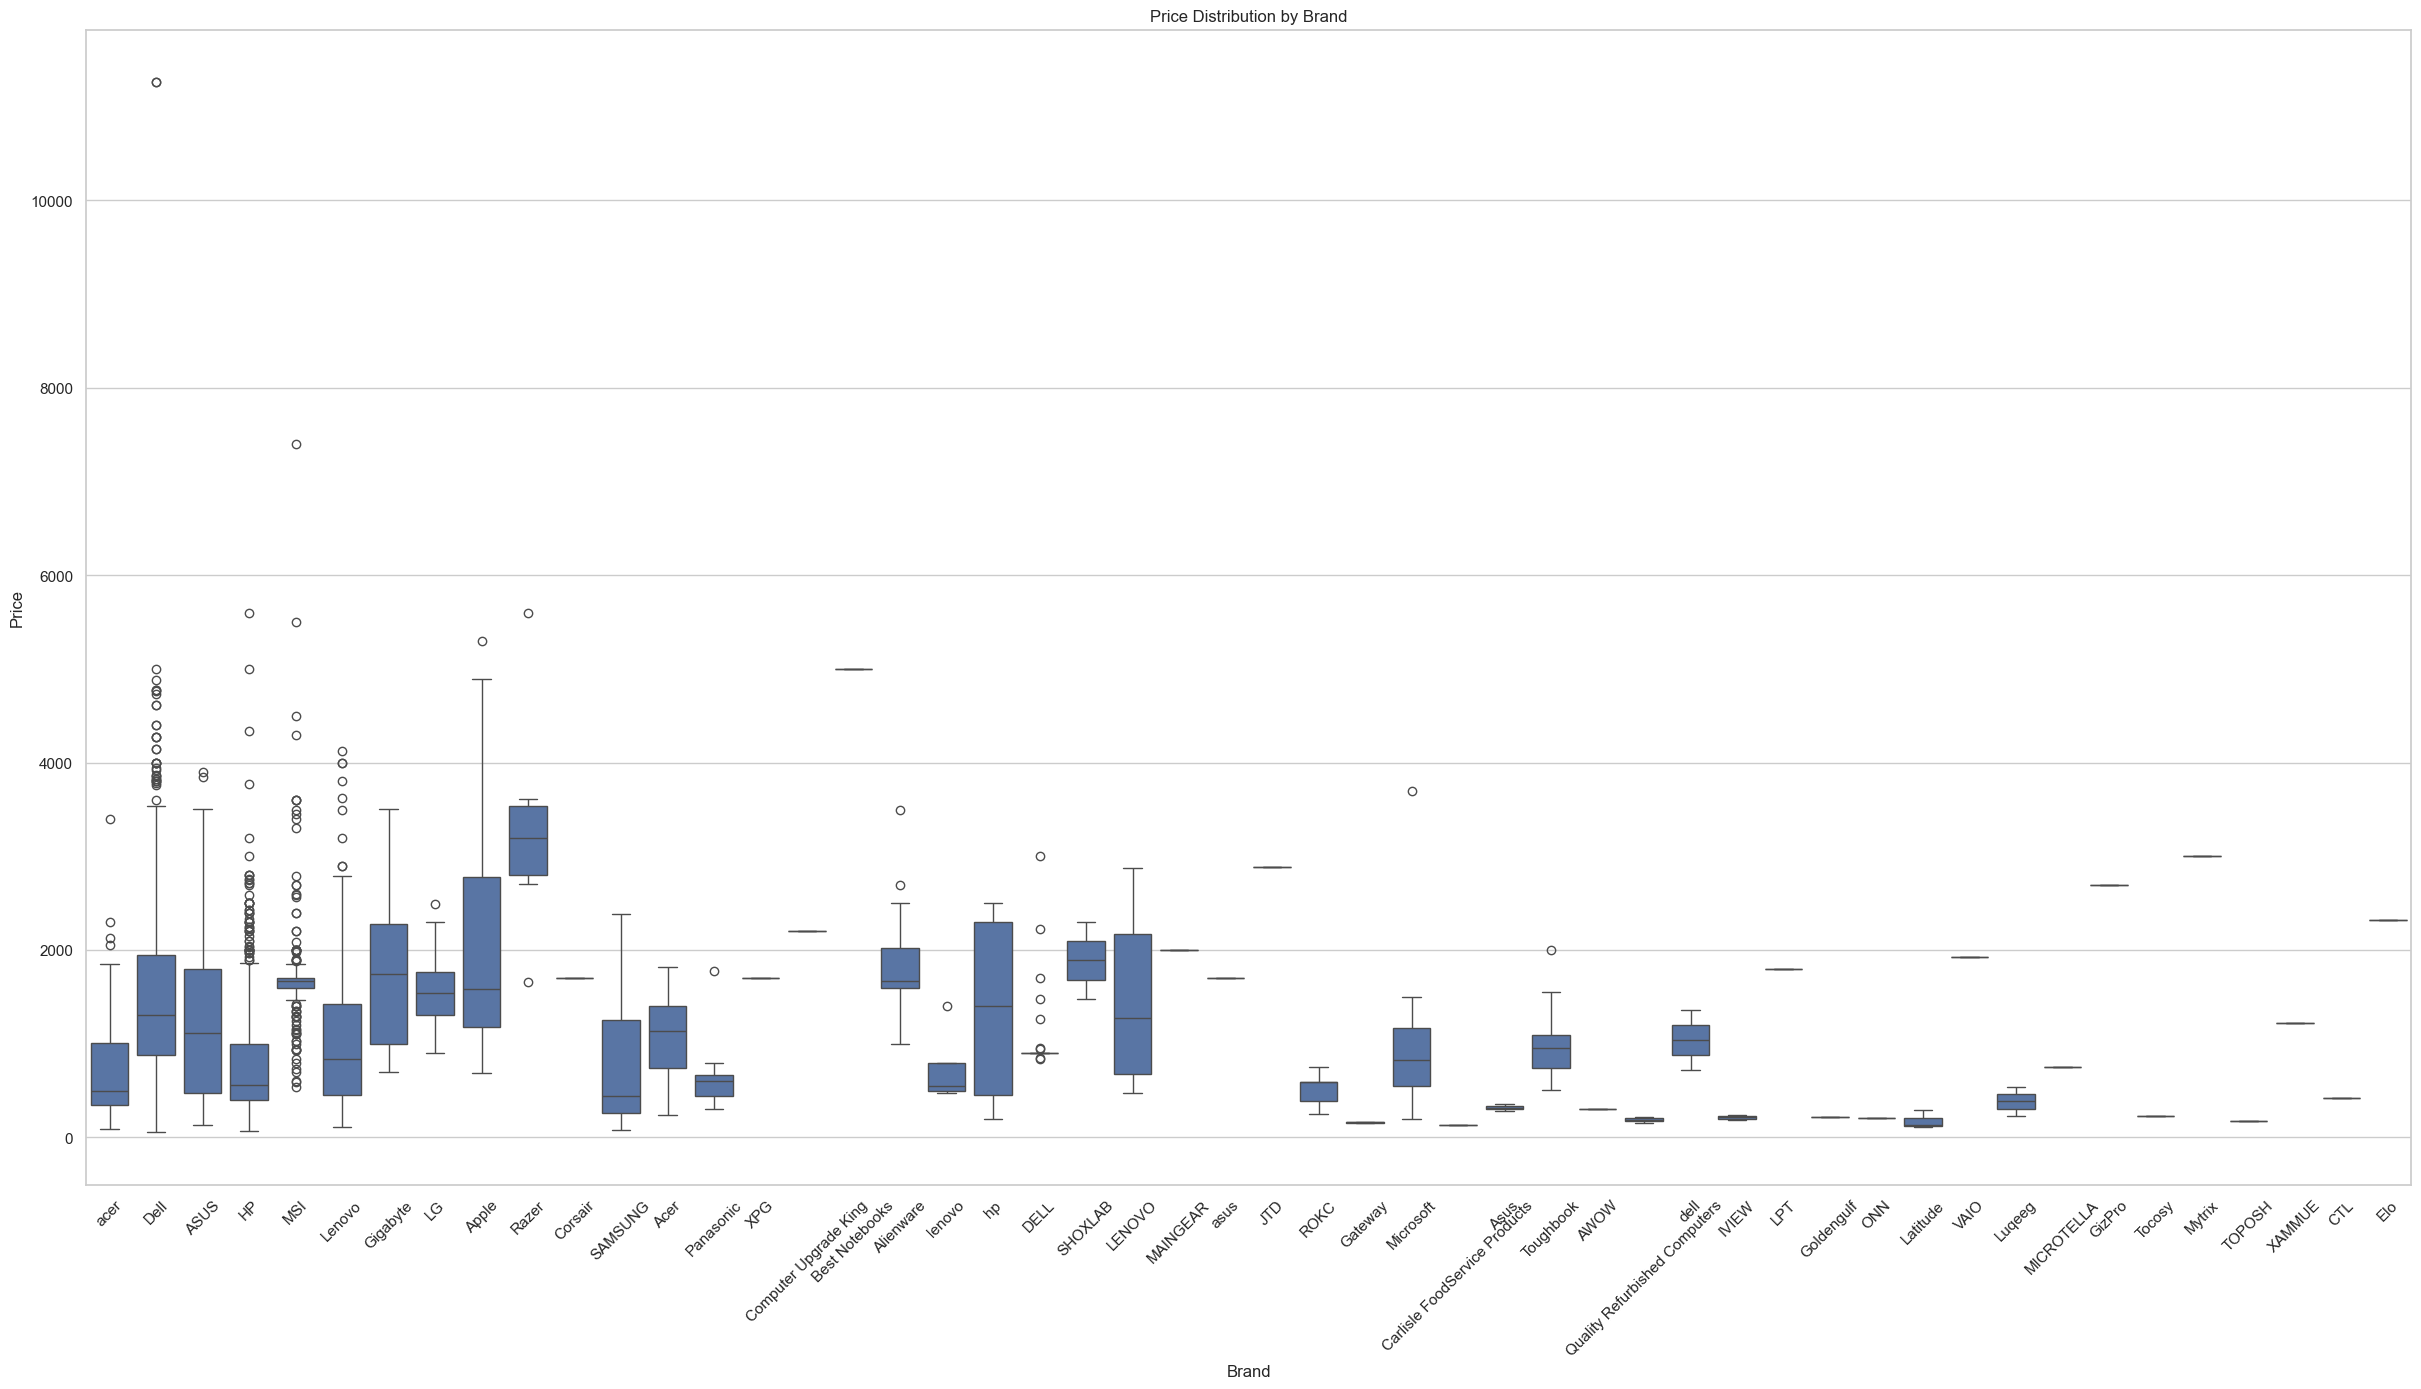

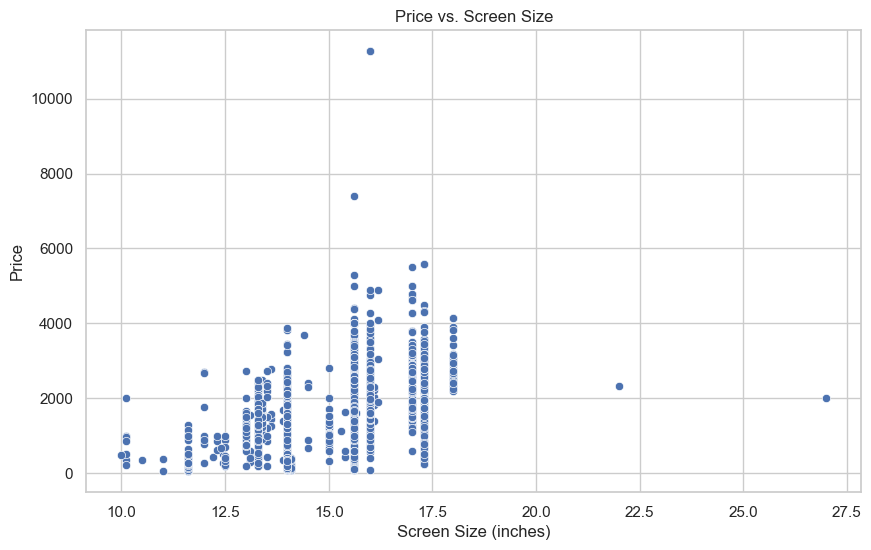

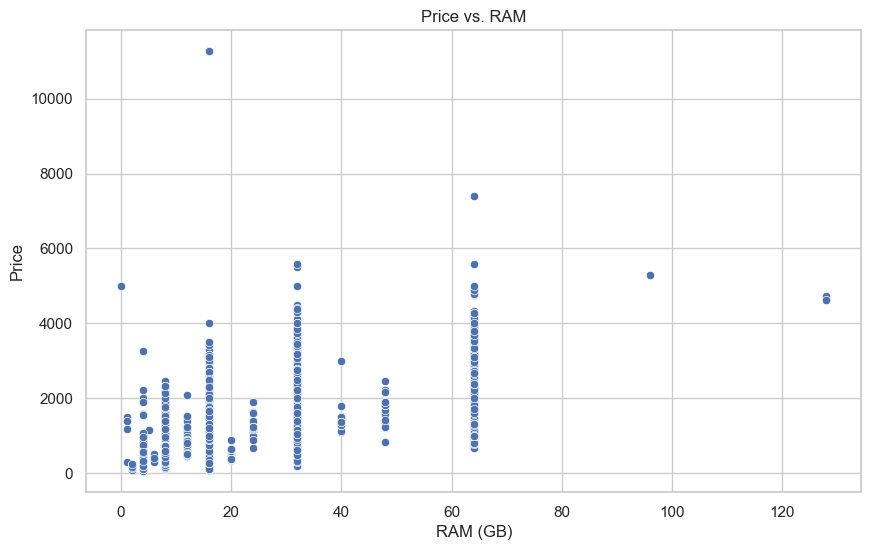

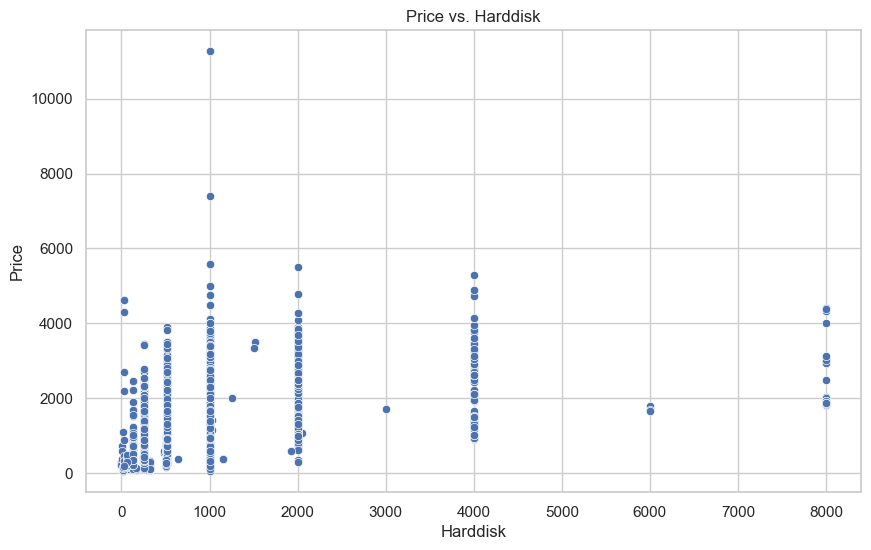

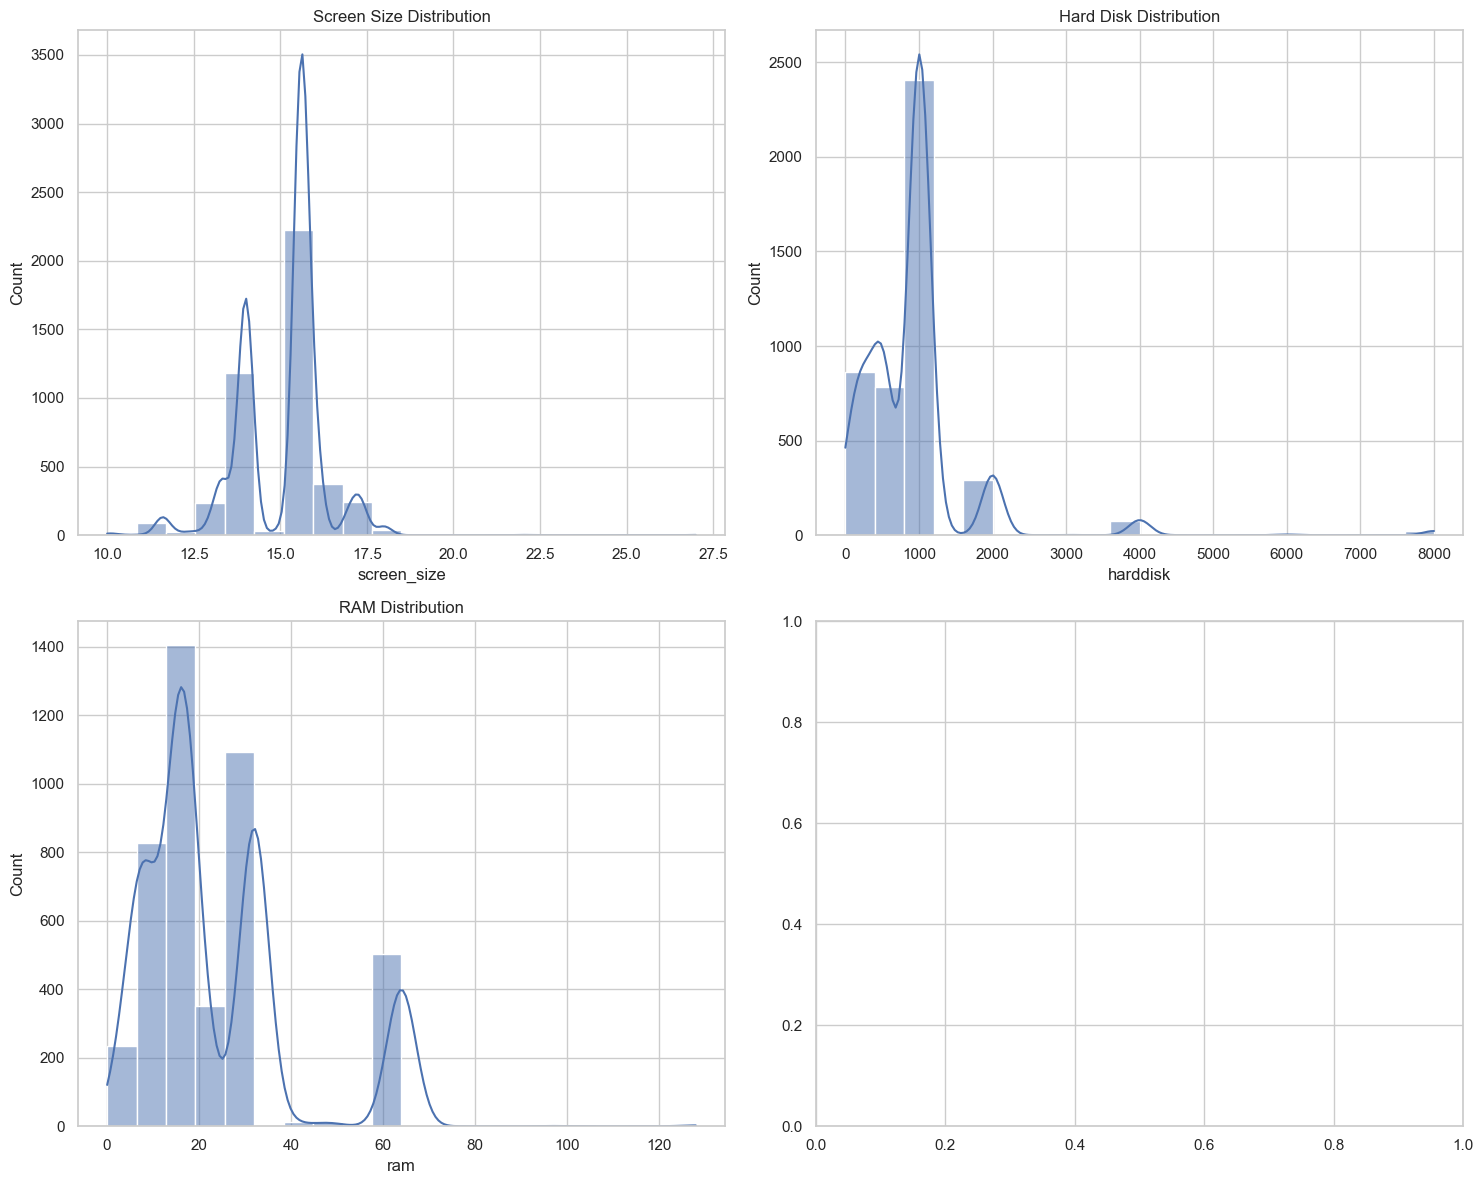

In [315]:
# Relationship between Brand and Price
plt.figure(figsize=(30, 15))
sns.boxplot(x='brand', y='price', data=laptopData_cleaned)
plt.xticks(rotation=45)
plt.title('Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.show()

# Relationship between Screen Size and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='screen_size', y='price', data=laptopData_cleaned)
plt.title('Price vs. Screen Size')
plt.xlabel('Screen Size (inches)')
plt.ylabel('Price')
plt.show()

# Relationship between RAM and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ram', y='price', data=laptopData_cleaned)
plt.title('Price vs. RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Price')
plt.show()

# Relationship between Harddisk and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='harddisk', y='price', data=laptopData_cleaned)
plt.title('Price vs. Harddisk')
plt.xlabel('Harddisk')
plt.ylabel('Price')
plt.show()

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Creating histograms for numerical features
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Screen Size Distribution
sns.histplot(laptopData_cleaned['screen_size'], bins=20, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Screen Size Distribution')

# Hard Disk Distribution
sns.histplot(laptopData_cleaned['harddisk'], bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Hard Disk Distribution')

# RAM Distribution
sns.histplot(laptopData_cleaned['ram'], bins=20, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('RAM Distribution')

plt.tight_layout()
plt.show()

In [316]:
# Identifying the categorical and numerical columns
categorical_cols = ['brand', 'cpu', 'OS', 'graphics']
numerical_cols = ['screen_size', 'harddisk', 'ram']

# Preparing the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preparing the features and target variable
X = laptopData_cleaned.drop('price', axis=1)
y = laptopData_cleaned['price']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the preprocessor on the training data and only transform the test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Checking the shape of the preprocessed data
X_train_preprocessed.shape, X_test_preprocessed.shape

((3552, 180), (889, 180))

In [317]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training the model
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return rmse, r2

# Initializing the models
linear_reg = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)
gradient_boost = GradientBoostingRegressor(random_state=42)

# Training and evaluating each model
linear_reg_rmse, linear_reg_r2 = train_and_evaluate_model(linear_reg, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
random_forest_rmse, random_forest_r2 = train_and_evaluate_model(random_forest, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
gradient_boost_rmse, gradient_boost_r2 = train_and_evaluate_model(gradient_boost, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Collecting the results
results = {
    'Linear Regression': {'RMSE': linear_reg_rmse, 'R2 Score': linear_reg_r2},
    'Random Forest': {'RMSE': random_forest_rmse, 'R2 Score': random_forest_r2},
    'Gradient Boosting': {'RMSE': gradient_boost_rmse, 'R2 Score': gradient_boost_r2}
}

results

{'Linear Regression': {'RMSE': 478.55679655901724,
  'R2 Score': 0.6973999159044428},
 'Random Forest': {'RMSE': 471.96592714585614, 'R2 Score': 0.7056775700715191},
 'Gradient Boosting': {'RMSE': 443.28168100778043,
  'R2 Score': 0.740365957442936}}

In [325]:
# Corrected Hyperparameter grid for RandomizedSearchCV
param_grid_corrected = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 11, 2),
    'max_features': ['sqrt', 'log2']
}

# Random Forest model
rf_corrected = GradientBoostingRegressor(random_state=42)

# Randomized search on hyper parameters with a smaller number of iterations for faster processing
rf_random_corrected = RandomizedSearchCV(estimator=rf_corrected, param_distributions=param_grid_corrected, n_iter=5, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random_corrected.fit(X_train_preprocessed, y_train)

# Best parameters
rf_random_corrected.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   1.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=6, n_estimators=500; t

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10}

In [324]:
# rf = RandomForestRegressor(random_state=42, n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=10)

# Initializing the Random Forest Regressor
rf_regressor = GradientBoostingRegressor(random_state=42, n_estimators=500, min_samples_split=10, min_samples_leaf=1, max_features='log2', max_depth=10)

# Training the model
rf_regressor.fit(X_train_preprocessed, y_train)

# Predicting on the test set
y_pred = rf_regressor.predict(X_test_preprocessed)

# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(430.93137076197394, 0.7546317932376106)

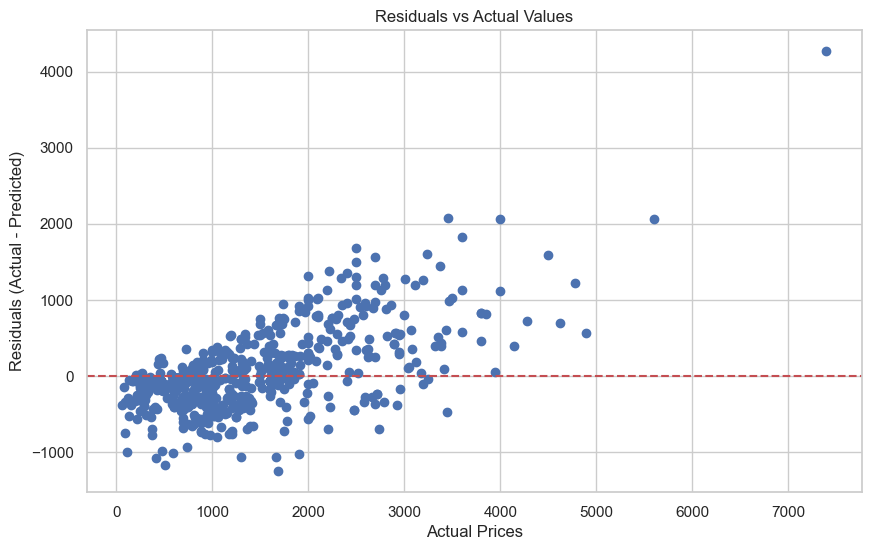

In [320]:
rounded_predictions = np.round(y_pred, 2)
# Calculating residuals
residuals = y_test - rounded_predictions

# Analyzing the residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.title("Residuals vs Actual Values")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [321]:
# Save the model
joblib.dump(rf_regressor, 'model/rf_regressor.joblib')

# Save the preprocessor
joblib.dump(preprocessor, 'model/preprocessor.joblib')

['model/preprocessor.joblib']